In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy.fft as fft  #we use scipy for the fft
import pandas as pd 

# 0. Function define 

## 0.1 Fourrier transform 

In [2]:
import numpy as np
from scipy.fft import fft, fftfreq

def PSD(signal, Fs):
    # Number of samples in the signal
    N = len(signal)
    
    # Compute the FFT values
    fft_values = fft(signal)
    
    # Compute the corresponding frequencies
    freq = fftfreq(N, 1 / Fs)
    
    # Only keep the positive frequencies
    pos_mask = freq >= 0
    
    # Return the positive frequencies and their magnitudes
    return freq[pos_mask], 2*np.abs(fft_values[pos_mask])/N

## 0.2 Power Spectral Density

In [3]:
def compute_fourier_transform(signal, sample_rate):
    """
    Computes the Fourier Transform of a given signal.
    
    Parameters:
    signal (numpy array): The input signal to be transformed.
    sample_rate (float): The sampling rate of the signal (in Hz).
    
    Returns:
    freq (numpy array): Frequencies corresponding to the Fourier Transform.
    amplitude (numpy array): Amplitude of the Fourier Transform at the given frequencies.
    """
    # Number of sample points
    N = len(signal)
    
    # Compute the Fourier Transform
    yf = fft(signal)
    
    # Compute the frequency bins
    xf = fftfreq(N, 1/sample_rate)[:N//2]
    
    # Compute the amplitude spectrum
    amplitude = 2.0/N * np.abs(yf[:N//2])
    
    return xf, amplitude

In [4]:

def compute_power_spectral_density(signal, sample_rate, nperseg):
    from scipy.signal import welch
    """
    Computes the Power Spectral Density (PSD) of a given signal using Welch's method.
    
    Parameters:
    signal (numpy array): The input signal.
    sample_rate (float): The sampling rate of the signal (in Hz).
    nperseg (int, optional): Length of each segment for Welch's method (default is 256).
    
    Returns:
    freq (numpy array): Frequencies at which the PSD is computed.
    psd (numpy array): Power Spectral Density at each frequency.
    """
    # Compute the Power Spectral Density using Welch's method
    freq, psd = welch(signal, sample_rate, nperseg=nperseg)
    return freq, np.sqrt(psd)
    

In [5]:
def compute_power_spectral_density(signal, sample_rate, nperseg, bandwidth):
    from scipy.signal import welch
    from scipy.signal.windows import hann
    """
    Computes the Power Spectral Density (PSD) of a given signal using Welch's method,
    considering the bandwidth of the oscilloscope.

    Parameters:
    signal (numpy array): The input signal.
    sample_rate (float): The sampling rate of the signal (in Hz).
    nperseg (int, optional): Length of each segment for Welch's method (default is 256).
    bandwidth (float): Bandwidth of the oscilloscope (in Hz).

    Returns:
    freq (numpy array): Frequencies at which the PSD is computed.
    psd (numpy array): Power Spectral Density at each frequency.
    """

    # Apply a Hanning window to the signal
    window = hann(nperseg)
    signal = signal * window

    # Compute the Power Spectral Density using Welch's method
    freq, psd = welch(signal, sample_rate, nperseg=nperseg)

    # Consider the oscilloscope's bandwidth
    valid_indices = freq <= bandwidth / 2  # Keep only frequencies within bandwidth
    freq = freq[valid_indices]
    psd = psd[valid_indices]

    return freq, np.sqrt(psd)
    

In [6]:
def PSD_avg(data, Fs, BW, nperseg):  # Added nperseg argument
    """
    Computes the average Power Spectral Density (PSD) of a given signal 
    over multiple segments.

    Parameters:
    data (numpy array): The input signal.
    Fs (float): The sampling rate of the signal (in Hz).
    BW (float): Bandwidth of the oscilloscope (in Hz).
    nperseg (int, optional): Length of each segment for Welch's method (default is 256).

    Returns:
    freq (numpy array): Frequencies at which the PSD is computed.
    avg_psd (numpy array): Average Power Spectral Density at each frequency.
    """
    L = len(data)
    n = int(L / Fs) 
    # print(n)
    psd_sum = np.zeros(L // n // 2 +1)  # Initialize array to store PSD sum
    # print(np.size(psd_sum))
    count = 0
    for i in range(n):
        # print(i)
        fre, val = compute_power_spectral_density(data[count:count + Fs], Fs, nperseg, BW)
        psd_sum += val 
        count += Fs

    avg_psd = psd_sum / n
    return fre, avg_psd  # Return the frequency array from the last segment
        

# 1. Noise plot 

### Compare

In [7]:
color = ['black', 'orange', 'green', 'red', 'brown']


In this analysis, there are something to note: 

1. The DAC's voltage measured within 10s by the Oscilloscope with BW = 1 GHz
2. DAC voltage converted into current using the relation below:
       $$ \sqrt{S_I} = \frac{n_{out}*2}{1000*510} = \frac{n_{out \times 2}}{510000}  * 10^{12} [pA]  $$ ($10^{12}$ to convert it into $pA$)
3. Data taken by Oscilloscope in 20s. With 50k sps/s with Board 1,6 and 1k sps/s for Board 4 (forgot to change)

Plot the measurement on different Asics Boards using different power source

* The power supply
* The filtered power supply
* The batteries 

## 1.1. AwaXe v4 

### 1.1.1 Read data 

Note that the file's name can be understand with the following instruction:

``` B [board number] + [ULTRA LOW FREQUENCY /LOW FREQUENCY/ HIGH FREQUENCY] + [Type of power source] ```


For example: ``` B5LFPS ``` : Board 5, Low frequency, power supply 

P/s: 

```UF ``` Ultra low frequency (from 0.1 to 10 Hz)

```LF ``` Low frequency (from 1 to 100 Hz)

```HF ``` High frequency (from 10 to 1000 Hz)



```PS ``` Power supply

```FF ``` Filtered Power Supply

```BA ``` Batteries 



------------------------

For the plot, we apply the gain 

$$G =  \frac{1e12}{510 \times 1000}$$

As $510$ is the resistance that we connect to convert current into voltage $[\Omega]$

$1000$ is the gain from the Stanford Research Amplifier 

$1e12$ the factor to convert the current into pico ampere 


-------------------------

In [8]:
factor = 1e12 / (510 * 1000) 

In [9]:
color = ['black', 'orange', 'green', 'red', 'brown']

In [10]:
B5LFPS = np.genfromtxt('data/AwaXev4_error/B5LFPS.TXT')
B5HFPS = np.genfromtxt('data/AwaXev4_error/B5HFPS.TXT')
B5LFFF = np.genfromtxt('data/AwaXev4_error/B5LFFF.TXT')
B5HFFF = np.genfromtxt('data/AwaXev4_error/B5HFFF.TXT')
B5LFBA = np.genfromtxt('data/AwaXev4_error/B5LFBA.TXT')
B5HFBA = np.genfromtxt('data/AwaXev4_error/B5HFBA.TXT')

### AwaXe v4 Board 5
 measure current density from TES DAC. Using spectral analyser 

Text(0.5, 1.0, ' DAC TES Current density measured in board 5 AwaXe v4')

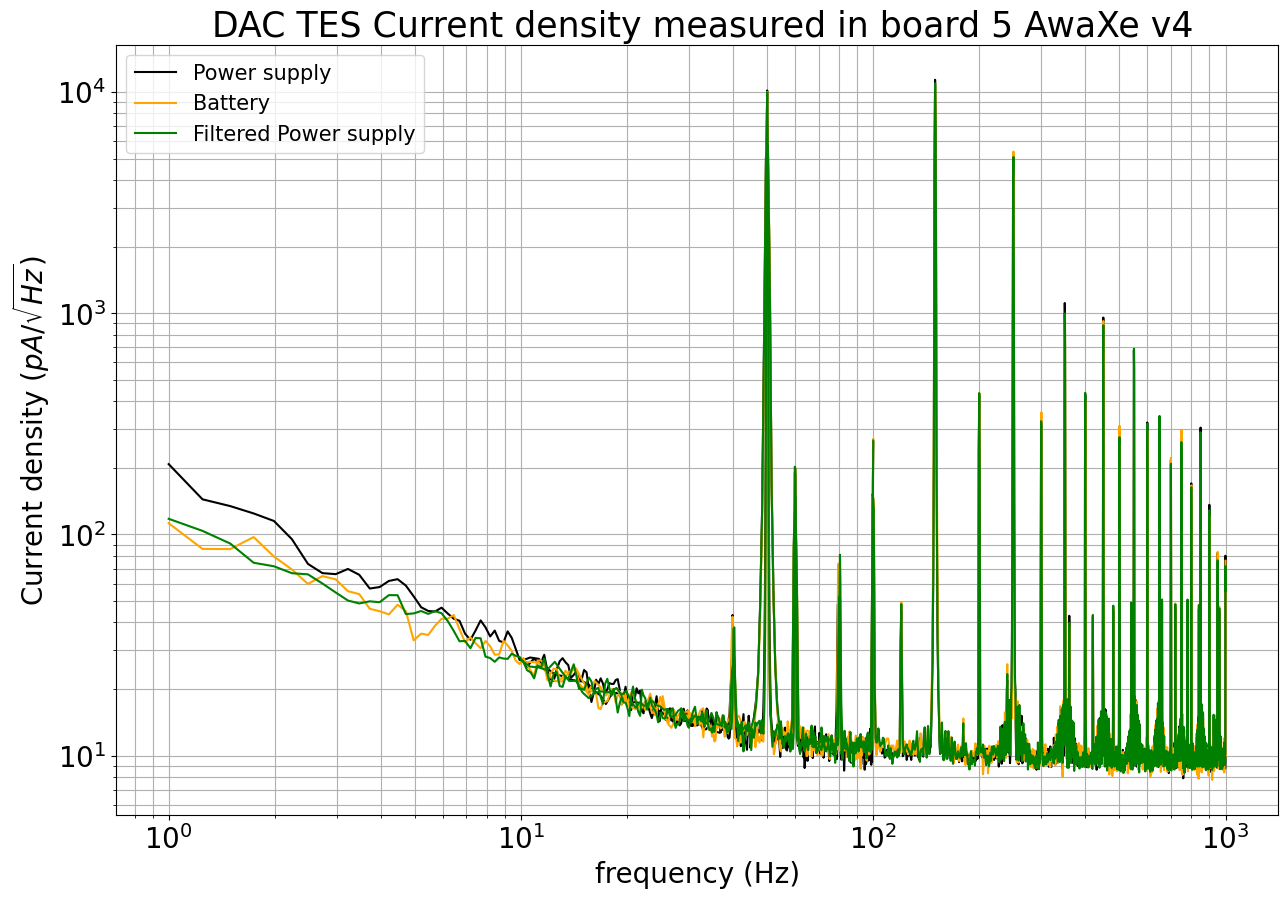

In [11]:
plt.figure(figsize = (15,10))
# plt.subplot(211)
plt.loglog(B5LFPS[:,0], B5LFPS[:,1]*factor, color = color[0], label = 'Power supply' )
plt.loglog(B5HFPS[:,0], B5HFPS[:,1]*factor, color = color[0] )
plt.loglog(B5LFBA[:,0], B5LFBA[:,1]*factor, color = color[1], label = 'Battery' )
plt.loglog(B5HFBA[:,0], B5HFBA[:,1]*factor, color = color[1] )
plt.loglog(B5LFFF[:,0], B5LFFF[:,1]*factor, color = color[2], label = 'Filtered Power supply' )
plt.loglog(B5HFFF[:,0], B5HFFF[:,1]*factor, color = color[2] )

plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r'Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.title(' DAC TES Current density measured in board 5 AwaXe v4',fontsize = 25) 


Anyway, the next day we realised that we didn't connect the board while measuring... So this one just plot the ambient noise

### 1.1.2. AwaXe v4, board 4

From now on, we will distinguished between TES DAC and SQUID DAC, so that we propose different way to name them 


``` [DAC type] + [board number] + [ULTRA LOW FREQUENCY /LOW FREQUENCY/ HIGH FREQUENCY] + [Type of power source] ```


For example: ``` S4LFPS ``` : Squid DAC, Board 4, Low frequency, power supply 

P/s: 

*DAC type*

``` S ``` Squid 

``` T ``` TES 


*Frequency range*

```UF ``` Ultra low frequency (from 0.1 to 10 Hz)

```LF ``` Low frequency (from 1 to 100 Hz)

```HF ``` High frequency (from 10 to 1000 Hz)


*Type of power supply*

```PS ``` Power supply

```FF ``` Filtered Power Supply

```BA ``` Batteries 

In [12]:
S4LFPS = np.genfromtxt('data/AwaXev4/S4LFPS.TXT')
S4HFPS = np.genfromtxt('data/AwaXev4/S4HFPS.TXT')
S4LFFF = np.genfromtxt('data/AwaXev4/S4LFFF.TXT')
S4HFFF = np.genfromtxt('data/AwaXev4/S4HFFF.TXT')
S4LFBA = np.genfromtxt('data/AwaXev4/S4LFBA.TXT')
S4HFBA = np.genfromtxt('data/AwaXev4/S4HFBA.TXT')
T4LFPS = np.genfromtxt('data/AwaXev4/T4LFPS.TXT')
T4HFPS = np.genfromtxt('data/AwaXev4/T4HFPS.TXT') 
T4LFFF = np.genfromtxt('data/AwaXev4/T4LFFF.TXT')
T4HFFF = np.genfromtxt('data/AwaXev4/T4HFFF.TXT')
T4LFBA = np.genfromtxt('data/AwaXev4/T4LFBA.TXT')
T4HFBA = np.genfromtxt('data/AwaXev4/T4HFBA.TXT')

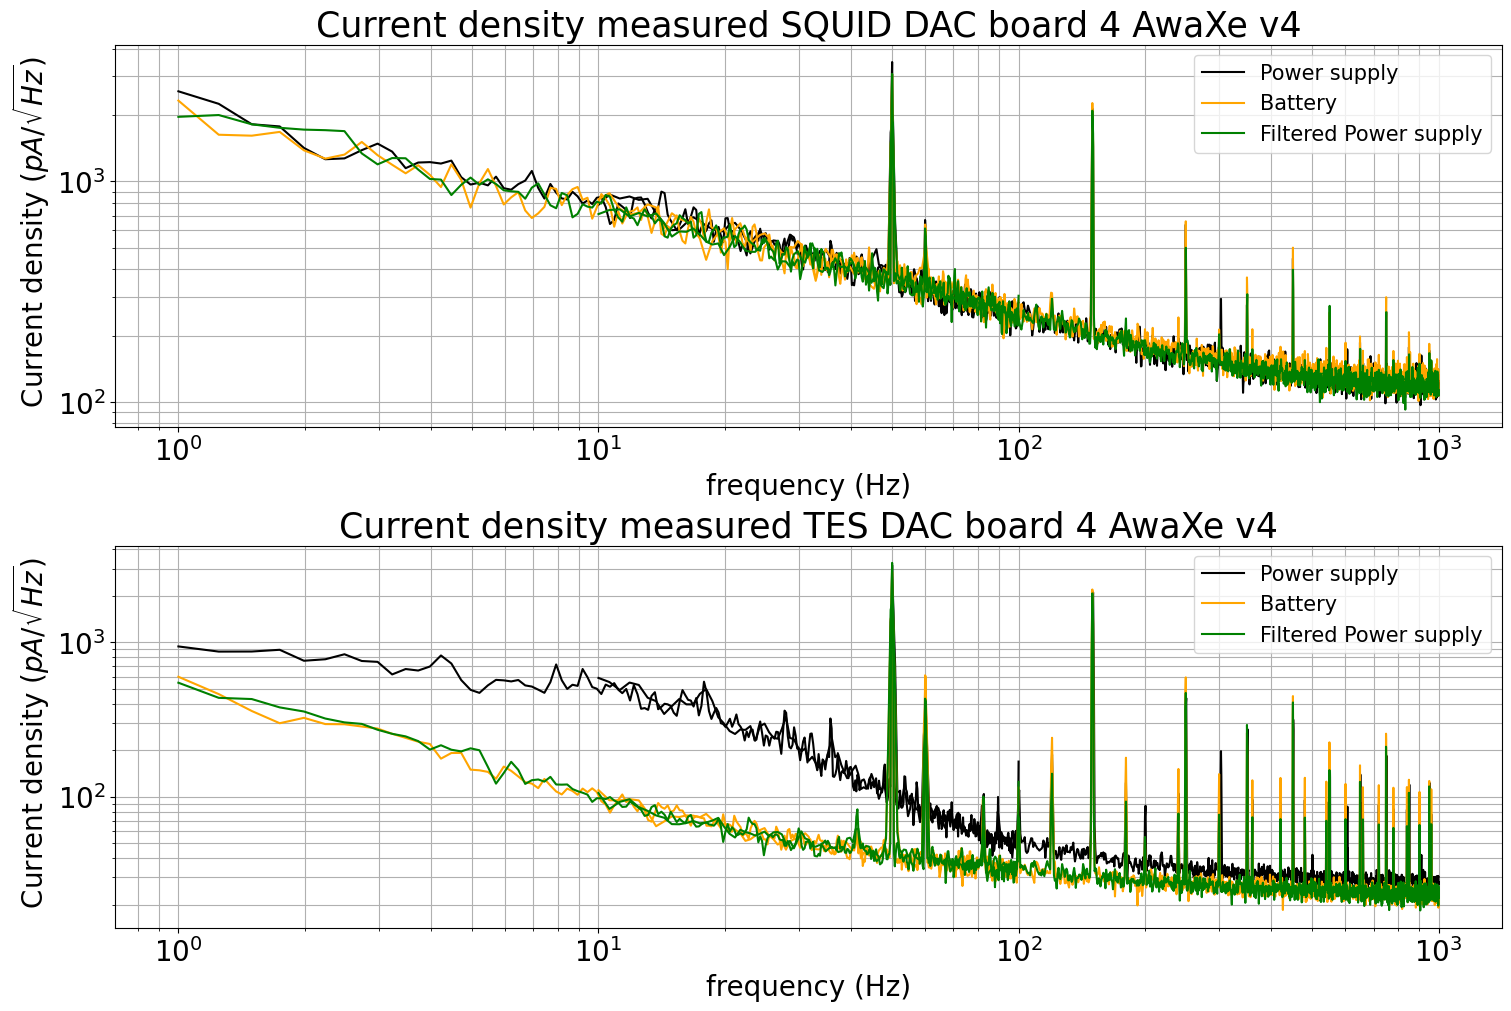

In [13]:

plt.figure(figsize = (15,10), constrained_layout=True)
plt.subplot(211)
plt.loglog(S4LFPS[:,0], S4LFPS[:,1]*factor, color = color[0], label = 'Power supply' )
plt.loglog(S4HFPS[:,0], S4HFPS[:,1]*factor, color = color[0] )
plt.loglog(S4LFBA[:,0], S4LFBA[:,1]*factor, color = color[1], label = 'Battery' )
plt.loglog(S4HFBA[:,0], S4HFBA[:,1]*factor, color = color[1] )
plt.loglog(S4LFFF[:,0], S4LFFF[:,1]*factor, color = color[2], label = 'Filtered Power supply' )
plt.loglog(S4HFFF[:,0], S4HFFF[:,1]*factor, color = color[2] )
plt.gca().set_title('Current density measured SQUID DAC board 4 AwaXe v4',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.subplot(212)
plt.loglog(T4LFPS[:,0], T4LFPS[:,1]*factor, color = color[0], label = 'Power supply' )
plt.loglog(T4HFPS[:,0], T4HFPS[:,1]*factor, color = color[0] )
plt.loglog(T4LFBA[:,0], T4LFBA[:,1]*factor, color = color[1], label = 'Battery' )
plt.loglog(T4HFBA[:,0], T4HFBA[:,1]*factor, color = color[1] )
plt.loglog(T4LFFF[:,0], T4LFFF[:,1]*factor, color = color[2], label = 'Filtered Power supply' )
plt.loglog(T4HFFF[:,0], T4HFFF[:,1]*factor, color = color[2] )
plt.gca().set_title('Current density measured TES DAC board 4 AwaXe v4',fontsize = 25) 
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.savefig('DAC_SQUID_TES_v4_board4.png')

In [14]:
S3LFFF = np.genfromtxt('data/AwaXev4/B3LFFF.TXT')
S3HFFF = np.genfromtxt('data/AwaXev4/B3HFFF.TXT')
S1LFFF = np.genfromtxt('data/AwaXev4/S1LFFF.TXT')
S1HFFF = np.genfromtxt('data/AwaXev4/S1HFFF.TXT')
S4LFFF = np.genfromtxt('data/AwaXev4/S4LFFF.TXT')
S4HFFF = np.genfromtxt('data/AwaXev4/S4HFFF.TXT')

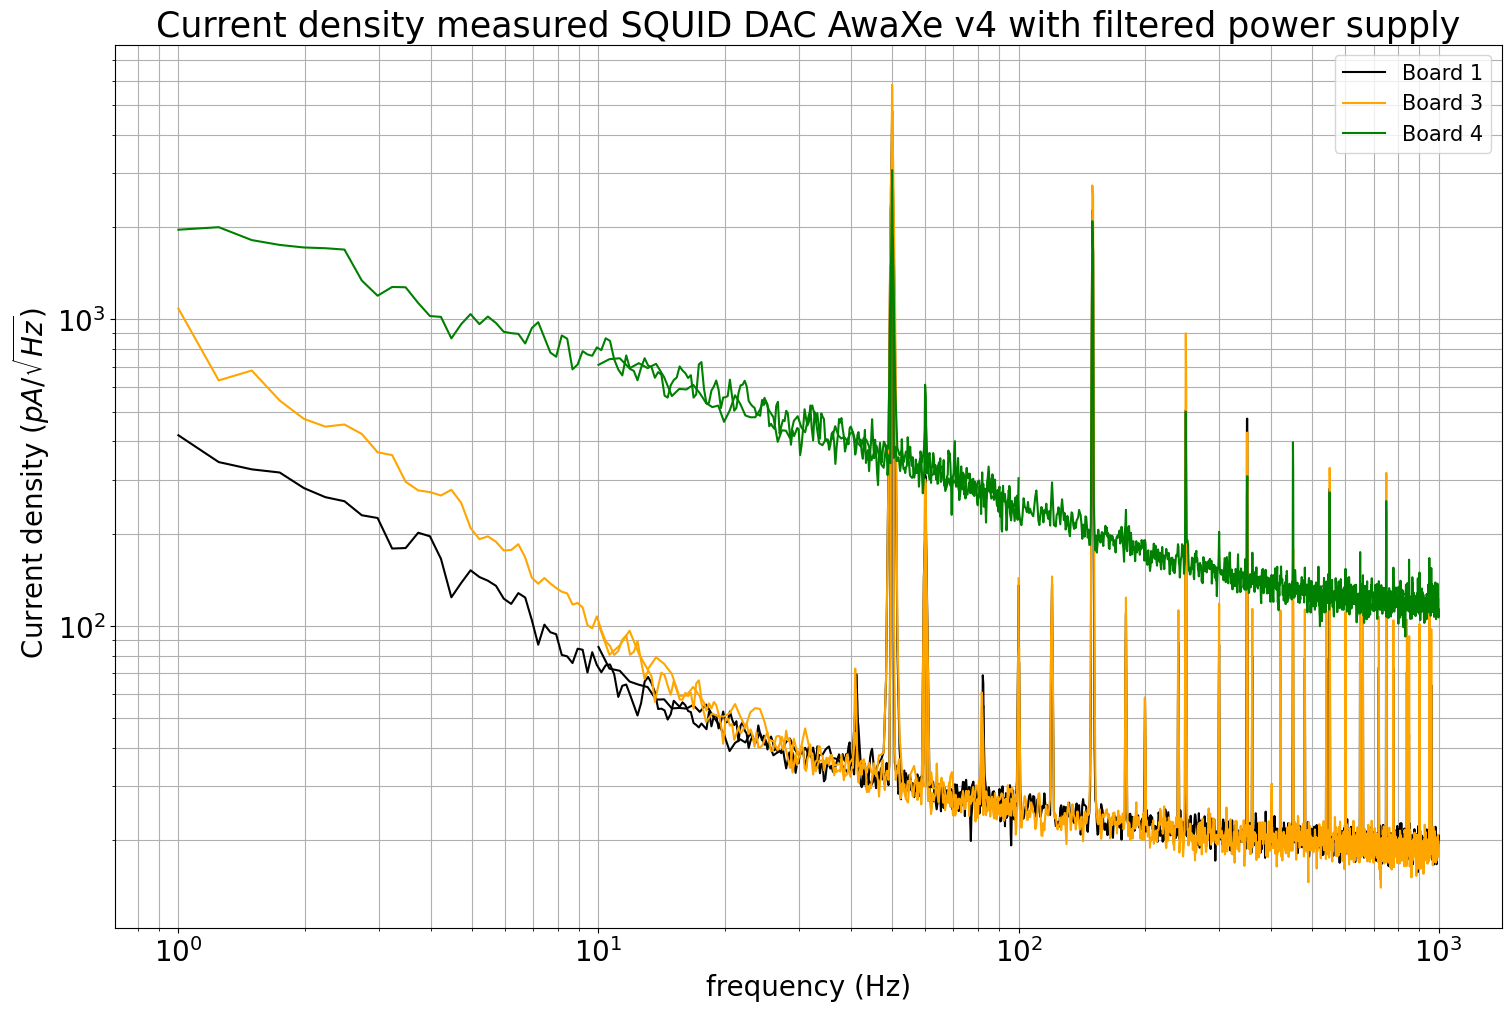

In [15]:
plt.figure(figsize = (15,10), constrained_layout=True)
# plt.subplot(211)
plt.loglog(S1LFFF[:,0], S1LFFF[:,1]*factor, color = color[0], label = 'Board 1' )
plt.loglog(S1HFFF[:,0], S1HFFF[:,1]*factor, color = color[0] )
plt.loglog(S3LFFF[:,0], S3LFFF[:,1]*factor, color = color[1], label = 'Board 3' )
plt.loglog(S3HFFF[:,0], S3HFFF[:,1]*factor, color = color[1] )
plt.loglog(S4LFFF[:,0], S4LFFF[:,1]*factor, color = color[2], label = 'Board 4' )
plt.loglog(S4HFFF[:,0], S4HFFF[:,1]*factor, color = color[2] )
plt.gca().set_title('Current density measured SQUID DAC AwaXe v4 with filtered power supply',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.savefig('DAC_SQUID_DAC_v4.png')

## 1.2 AwaXe v4.5

Not like **AwaXev4**, the ASIC board **AwaXev4.5** has 2 TES DAC and 2 SQUID DAC. So we have to name the file in different way 


``` [Board number] + [45] + [DAC type] + [DAC order] + [ULTRA LOW FREQUENCY /LOW FREQUENCY/ HIGH FREQUENCY] + [Type of power source] ```


For example: ``` 345T2LPS ``` : Board 3, AwaXe4.5, TES 2, Low frequency, Power supply  

P/s: 

*DAC type*

``` S ``` Squid 

``` T ``` TES 


*Frequency range*

```U ``` Ultra low frequency (from 0.1 to 10 Hz)

```L ``` Low frequency (from 1 to 100 Hz)

```H ``` High frequency (from 10 to 1000 Hz)


*Type of power supply*

```PS ``` Power supply

```FF ``` Filtered Power Supply

```BA ``` Batteries 

### 1.2.1. Board 3

For this board, we also measure the data using osciloscope in order to compare with the spectral analyser and unify the analysing way for Oscilloscope's data 

In [16]:
TES1_LF =      np.genfromtxt('data/AwaXev4.5/345T1LPS.TXT') 
TES2_LF =      np.genfromtxt('data/AwaXev4.5/345T2LPS.TXT') 
TES1_HF =      np.genfromtxt('data/AwaXev4.5/345T1HPS.TXT') 
TES2_HF =      np.genfromtxt('data/AwaXev4.5/345T2HPS.TXT')
SQI1_LF =      np.genfromtxt('data/AwaXev4.5/345S1LPS.TXT') 
SQI2_LF =      np.genfromtxt('data/AwaXev4.5/345S2LPS.TXT')
SQI1_HF =      np.genfromtxt('data/AwaXev4.5/345S1HPS.TXT') 
SQI2_HF =      np.genfromtxt('data/AwaXev4.5/345S2HPS.TXT')
TES2_UF =      np.genfromtxt('data/AwaXev4.5/345T2UPS.TXT') 
SQI2_UF =      np.genfromtxt('data/AwaXev4.5/345S2UPS.TXT') 
SPECTRO_TES2 = np.genfromtxt('data/AwaXev4.5/CMPT2HPS.TXT')
SPECTRO_SQI2 = np.genfromtxt('data/AwaXev4.5/CMPS2HPS.TXT')
OSCILLO_TES2 =   pd.read_csv('data/AwaXev4.5/cmpt2hps.Wfm.csv', skiprows=0, header=None) # No header
OSCILLO_SQI2 =   pd.read_csv('data/AwaXev4.5/cmps2hps.Wfm.csv', skiprows=0, header=None) # No header

#### v4.5, Board 3, with power supply 

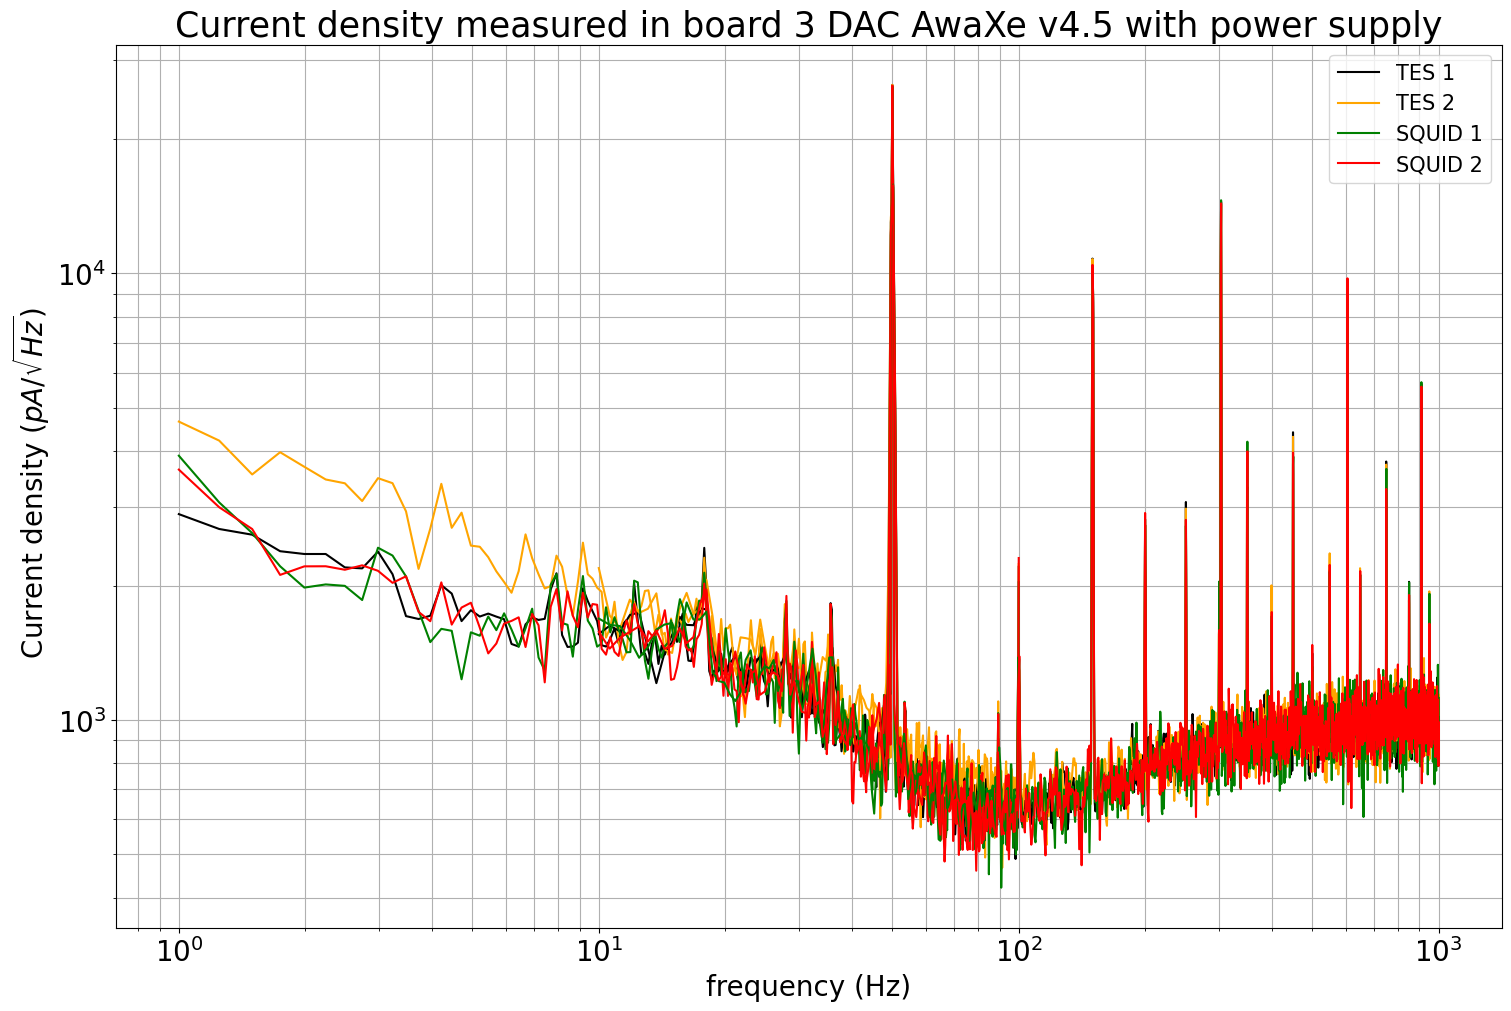

In [17]:
plt.figure(figsize = (15,10), constrained_layout=True)
# plt.subplot(211)

#TES_LF 
plt.loglog(TES1_LF[:,0], TES1_LF[:,1]*factor, color = color[0], label = 'TES 1' )
plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor, color = color[1], label = 'TES 2' )
#TES_HF 
plt.loglog(TES1_HF[:,0], TES1_HF[:,1]*factor, color = color[0] )
plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor, color = color[1] )
#SQUID_LF 
plt.loglog(SQI1_LF[:,0], SQI1_LF[:,1]*factor, color = color[2], label = 'SQUID 1' )
plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor, color = color[3], label = 'SQUID 2' )
#SQUID_HF 
plt.loglog(SQI1_HF[:,0], SQI1_HF[:,1]*factor, color = color[2] )
plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor, color = color[3] )


plt.gca().set_title('Current density measured in board 3 DAC AwaXe v4.5 with power supply',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.savefig('board3_v4.5_TES12_SQUID12.png')

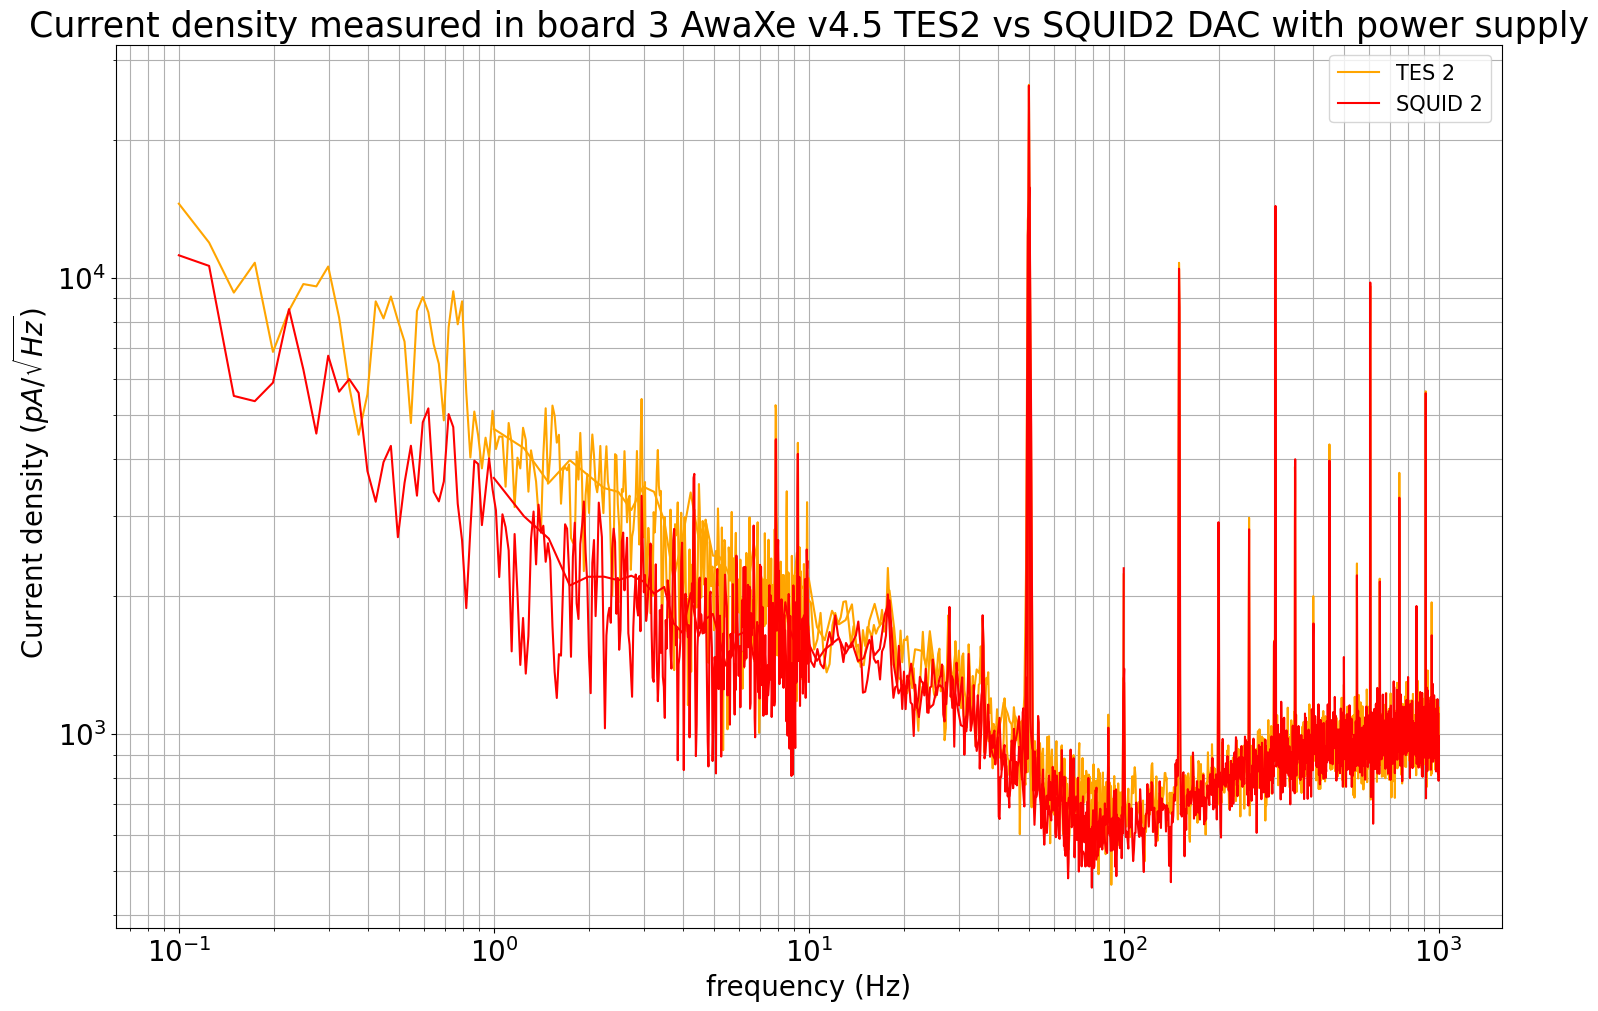

In [18]:
plt.figure(figsize = (15,10), constrained_layout=True)
# plt.subplot(211)
#TES_UF 
plt.loglog(TES2_UF[:,0], TES2_UF[:,1]*factor, color = color[1])
#TES_LF 
plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor, color = color[1], label = 'TES 2' )
#TES_HF 
plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor, color = color[1] )
#SQID_UF 
plt.loglog(SQI2_UF[:,0], SQI2_UF[:,1]*factor, color = color[3] )
#SQUID_LF 
plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor, color = color[3], label = 'SQUID 2' )
#SQUID_HF 
plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor, color = color[3] )


plt.gca().set_title('Current density measured in board 3 AwaXe v4.5 TES2 vs SQUID2 DAC with power supply',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.savefig('board3_v4.5_TES2_SQUID2_ultralownoise.png')

In [40]:
sample_rate = 20000
ft1,val1 = compute_power_spectral_density(OSCILLO_TES2[0]*factor, sample_rate, len(OSCILLO_TES2[0]), 20e6)
ft2,val2 = compute_power_spectral_density(OSCILLO_SQI2[0]*factor, sample_rate, len(OSCILLO_SQI2[0]), 20e6)

In [ ]:
plt.figure()

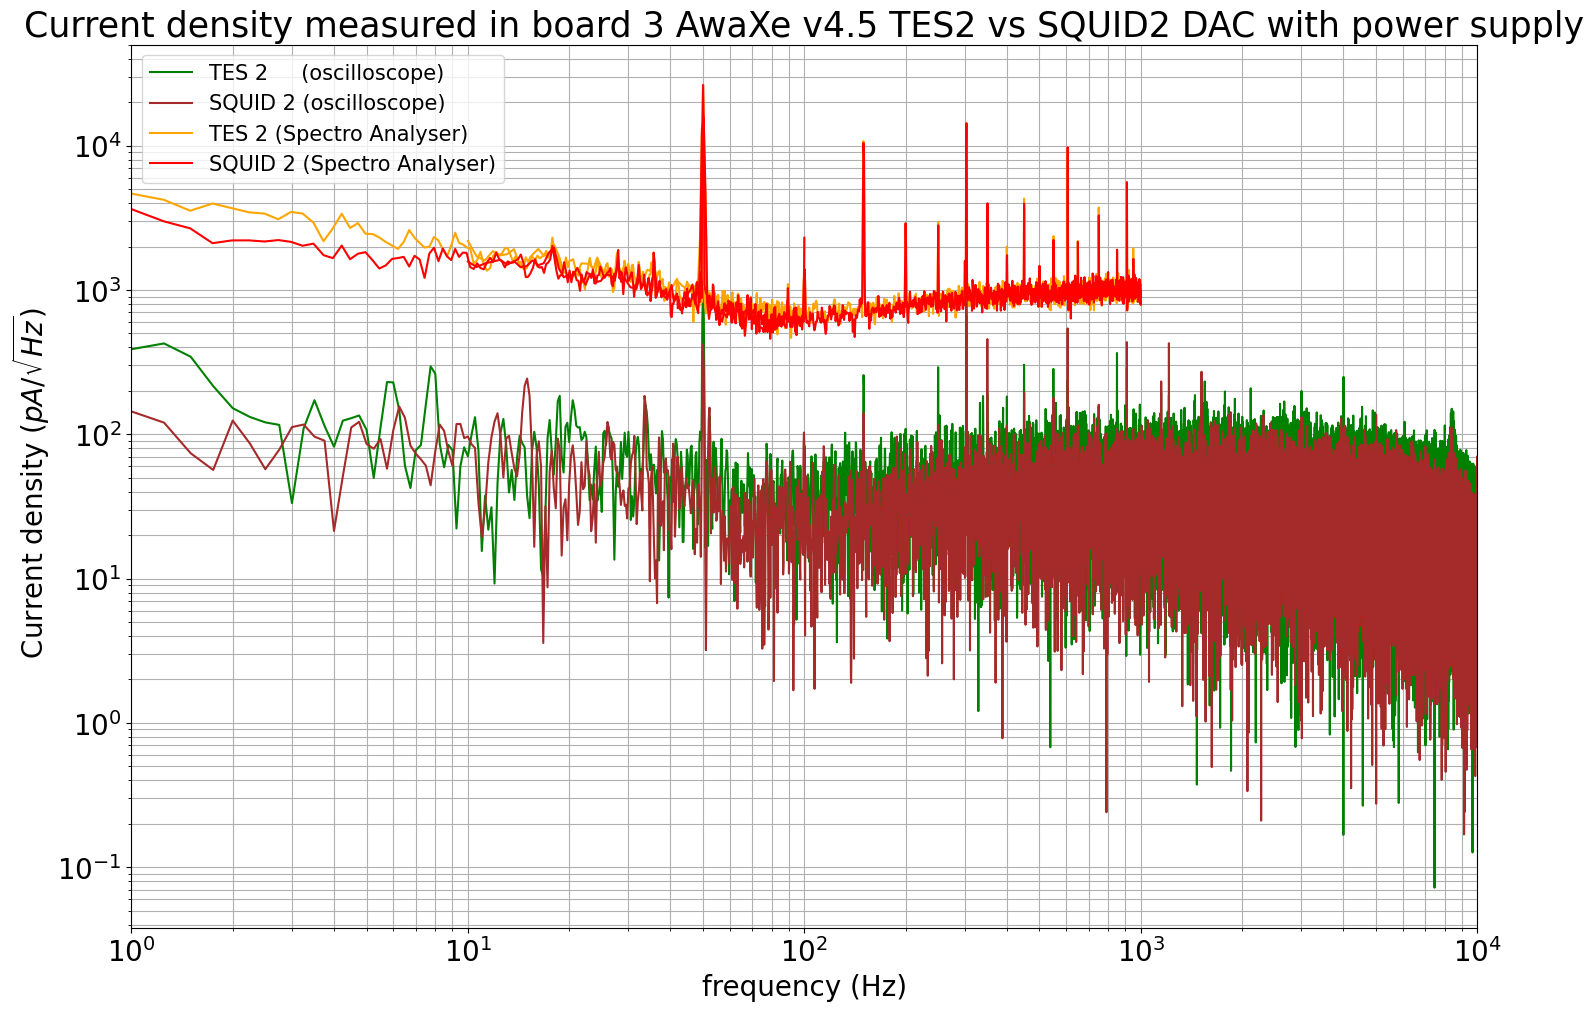

In [41]:
plt.figure(figsize = (15,10), constrained_layout=True)
# plt.subplot(211)

# #TES_LF 
# plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor, color = color[1], label = 'TES 2' )
# #TES_HF 
# plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor, color = color[1] )

# #SQUID_LF 
# plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor, color = color[3], label = 'SQUID 2' )
# #SQUID_HF 
# plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor, color = color[3] )

#Oscilloscope 
plt.loglog(ft1,val1, color = color[2], label = 'TES 2     (oscilloscope)')
plt.loglog(ft2,val2, color = color[4], label = 'SQUID 2 (oscilloscope)')

#TES_LF 
plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor, color = color[1], label = 'TES 2 (Spectro Analyser)' )
#TES_HF 
plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor, color = color[1] )

#SQUID_LF 
plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor, color = color[3], label = 'SQUID 2 (Spectro Analyser)' )
#SQUID_HF 
plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor, color = color[3] )


plt.gca().set_title('Current density measured in board 3 AwaXe v4.5 TES2 vs SQUID2 DAC with power supply',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.xlim(1,1e4)
plt.savefig('spectrum_compare.png')

#### v4.5, board 3 with batteries

In [21]:
### TES_LF
TES1BA_LF = np.genfromtxt('data/AwaXev4.5/345T1LBA.TXT') 
TES2BA_LF = np.genfromtxt('data/AwaXev4.5/345T2LBA.TXT') 
TES1BA_HF = np.genfromtxt('data/AwaXev4.5/345T1HBA.TXT') 
TES2BA_HF = np.genfromtxt('data/AwaXev4.5/345T2HBA.TXT')
SQI1BA_LF = np.genfromtxt('data/AwaXev4.5/345S1LBA.TXT') 
SQI2BA_LF = np.genfromtxt('data/AwaXev4.5/345S2LBA.TXT')
SQI1BA_HF = np.genfromtxt('data/AwaXev4.5/345S1HBA.TXT') 
SQI2BA_HF = np.genfromtxt('data/AwaXev4.5/345S2HBA.TXT')
TES2BA_UF = np.genfromtxt('data/AwaXev4.5/345T2UBA.TXT')
TES2BA_UF = np.genfromtxt('data/AwaXev4.5/345T2UBA.TXT') 
SQI2BA_UF = np.genfromtxt('data/AwaXev4.5/345S2UBA.TXT') 
TES1BA_UF = np.genfromtxt('data/AwaXev4.5/345T1UBA.TXT') 
SQI1BA_UF = np.genfromtxt('data/AwaXev4.5/345S1UBA.TXT') 
# ### DATA to try compare 
# SPECTRO_TES2 = np.genfromtxt('v4.5/CMPT2HPS.TXT')
# SPECTRO_SQI2 = np.genfromtxt('v4.5/CMPS2HPS.TXT')

# OSCILLO_TES2 = pd.read_csv('v4.5/cmpt2hps.Wfm.csv', skiprows=0, header=None) # No header
# OSCILLO_SQI2 = pd.read_csv('v4.5/cmps2hps.Wfm.csv', skiprows=0, header=None) # No header

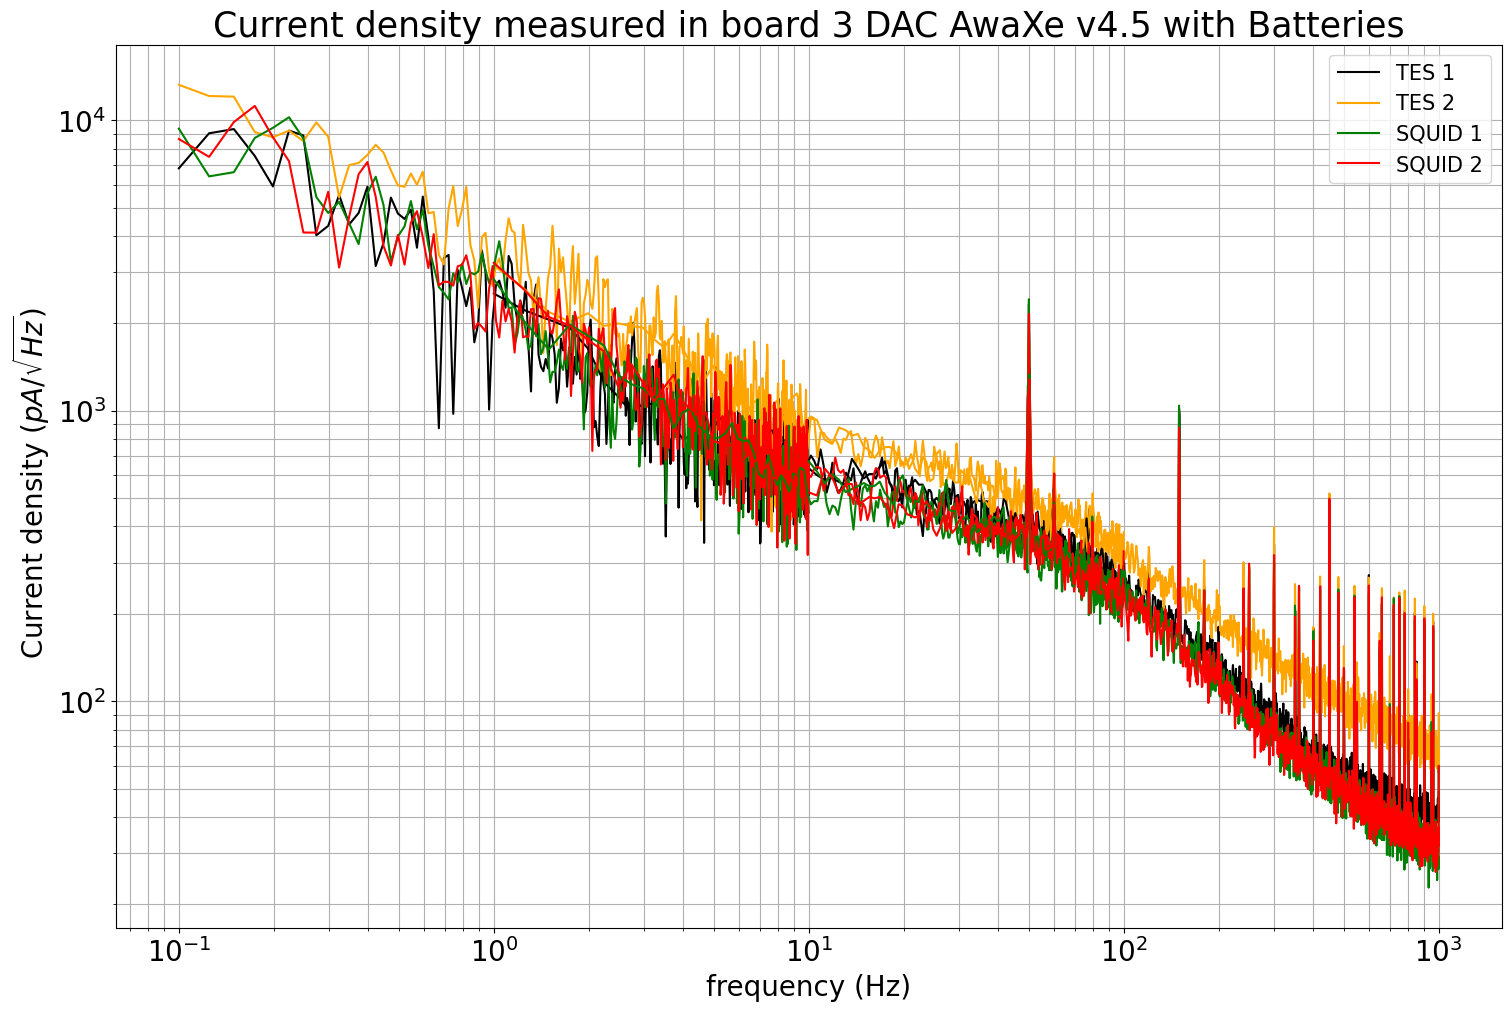

In [22]:
plt.figure(figsize = (15,10), constrained_layout=True)
# plt.subplot(211)

#TES_LF 
plt.loglog(TES1BA_UF[:,0], TES1BA_UF[:,1]*factor, color = color[0] )
plt.loglog(TES2BA_UF[:,0], TES2BA_UF[:,1]*factor, color = color[1] )
plt.loglog(TES1BA_LF[:,0], TES1BA_LF[:,1]*factor, color = color[0], label = 'TES 1' )
plt.loglog(TES2BA_LF[:,0], TES2BA_LF[:,1]*factor, color = color[1], label = 'TES 2' )
plt.loglog(TES1BA_HF[:,0], TES1BA_HF[:,1]*factor, color = color[0] )
plt.loglog(TES2BA_HF[:,0], TES2BA_HF[:,1]*factor, color = color[1] )

plt.loglog(SQI1BA_UF[:,0], SQI1BA_UF[:,1]*factor, color = color[2] )
plt.loglog(SQI2BA_UF[:,0], SQI2BA_UF[:,1]*factor, color = color[3] )
plt.loglog(SQI1BA_LF[:,0], SQI1BA_LF[:,1]*factor, color = color[2], label = 'SQUID 1' )
plt.loglog(SQI2BA_LF[:,0], SQI2BA_LF[:,1]*factor, color = color[3], label = 'SQUID 2' )
plt.loglog(SQI1BA_HF[:,0], SQI1BA_HF[:,1]*factor, color = color[2] )
plt.loglog(SQI2BA_HF[:,0], SQI2BA_HF[:,1]*factor, color = color[3] )



plt.gca().set_title('Current density measured in board 3 DAC AwaXe v4.5 with Batteries',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

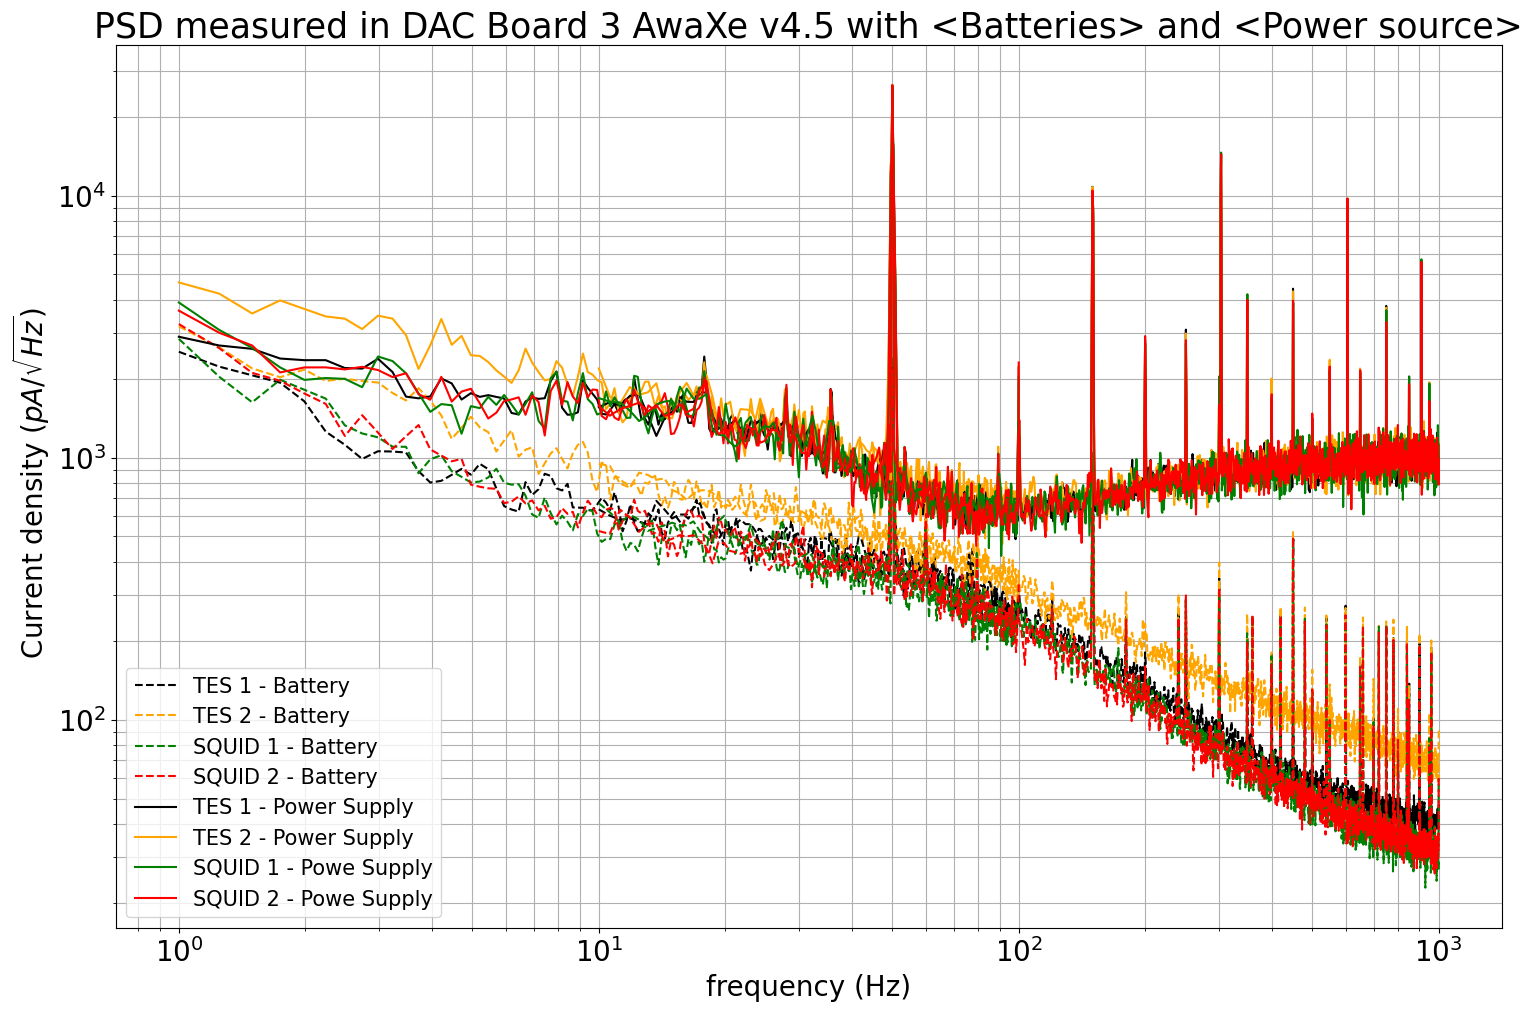

In [23]:
plt.figure(figsize = (15,10), constrained_layout=True)
# plt.subplot(211)

#TES_LF 
plt.loglog(TES1BA_LF[:,0], TES1BA_LF[:,1]*factor,linestyle = 'dashed', color = color[0], label = 'TES 1 - Battery' )
plt.loglog(TES2BA_LF[:,0], TES2BA_LF[:,1]*factor,linestyle = 'dashed', color = color[1], label = 'TES 2 - Battery' )
plt.loglog(TES1BA_HF[:,0], TES1BA_HF[:,1]*factor,linestyle = 'dashed', color = color[0] )
plt.loglog(TES2BA_HF[:,0], TES2BA_HF[:,1]*factor,linestyle = 'dashed', color = color[1] )
plt.loglog(SQI1BA_LF[:,0], SQI1BA_LF[:,1]*factor,linestyle = 'dashed', color = color[2], label = 'SQUID 1 - Battery' )
plt.loglog(SQI2BA_LF[:,0], SQI2BA_LF[:,1]*factor,linestyle = 'dashed', color = color[3], label = 'SQUID 2 - Battery' )
plt.loglog(SQI1BA_HF[:,0], SQI1BA_HF[:,1]*factor,linestyle = 'dashed', color = color[2] )
plt.loglog(SQI2BA_HF[:,0], SQI2BA_HF[:,1]*factor,linestyle = 'dashed', color = color[3] )

#------

#TES_LF 
plt.loglog(TES1_LF[:,0], TES1_LF[:,1]*factor, color = color[0], label = 'TES 1 - Power Supply' )
plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor, color = color[1], label = 'TES 2 - Power Supply' )
#TES_HF 
plt.loglog(TES1_HF[:,0], TES1_HF[:,1]*factor, color = color[0] )
plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor, color = color[1] )
#SQUID_LF 
plt.loglog(SQI1_LF[:,0], SQI1_LF[:,1]*factor, color = color[2], label = 'SQUID 1 - Powe Supply' )
plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor, color = color[3], label = 'SQUID 2 - Powe Supply' )
#SQUID_HF 
plt.loglog(SQI1_HF[:,0], SQI1_HF[:,1]*factor, color = color[2] )
plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor, color = color[3] )

plt.gca().set_title('PSD measured in DAC Board 3 AwaXe v4.5 with <Batteries> and <Power source>',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

### 1.2.2 Analyse and plot oscilloscope data of v4.5 board 3 (with battery)

Some note for analyse the data:

* Amplified by SR with ``` G = 1000 ``` and with analog LPF ``` Fc = 3kHz ```
* Measure by Oscilloscope with ``` BW = 20 MHz ```
* Measure in ``` T = 40s ```
* Sampling frequency ```Fs = 20 kHz```

In [24]:
### Oscilloscope 

OSCILLO_TES2BA = pd.read_csv('data/AwaXev4.5/345t2ba.Wfm.csv', skiprows=0, header=None) # No header
OSCILLO_SQI2BA = pd.read_csv('data/AwaXev4.5/345s2ba.Wfm.csv', skiprows=0, header=None) # No header
OSCILLO_TES1BA = pd.read_csv('data/AwaXev4.5/345t1ba.Wfm.csv', skiprows=0, header=None) # No header
OSCILLO_SQI1BA = pd.read_csv('data/AwaXev4.5/345s1ba.Wfm.csv', skiprows=0, header=None) # No header

In [25]:
OSCILLO_analyse = [OSCILLO_TES1BA,
OSCILLO_TES2BA,
OSCILLO_SQI1BA,
OSCILLO_SQI2BA]

We show two waveform in order to compare:
* Original power spectral density (where power spectral density has been calculated with full data range)
* Average power spectral density that calculated by sampling data into different sub-data with 1s period range, after that we average all of these power spectral density 

200001


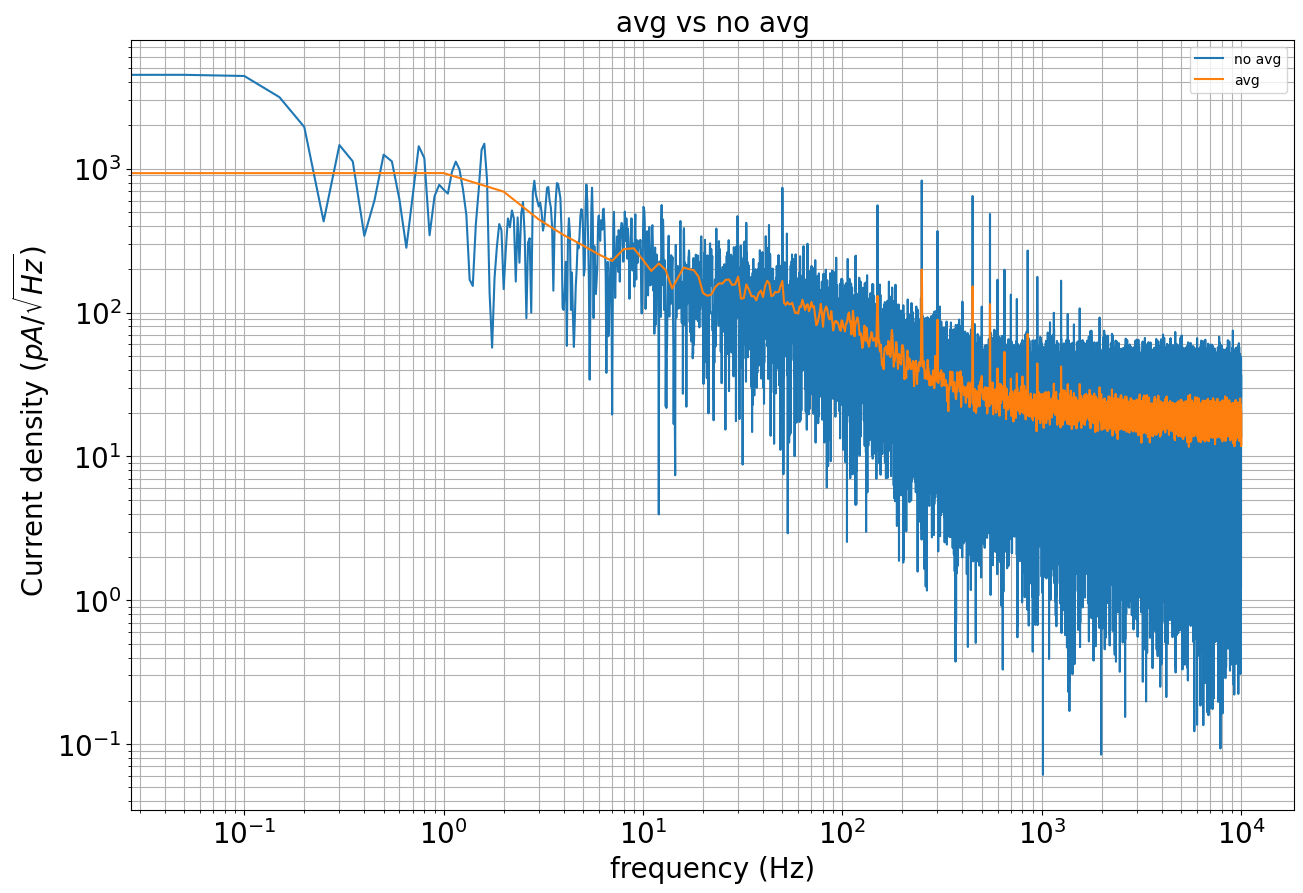

In [26]:
Fs = 20000
BW = 20e6

f_avg,va_avg = PSD_avg(OSCILLO_TES1BA[0]*factor                      , Fs, BW, 20000)
f_noavg, va_noavg = compute_power_spectral_density(OSCILLO_TES1BA[0]*factor, Fs, len(OSCILLO_TES1BA[0]), BW)
print(len(va_noavg))
plt.figure(figsize = (15,10))
plt.title('avg vs no avg', fontsize = 20)
plt.loglog(f_noavg, va_noavg, label = 'no avg')
plt.loglog(f_avg, va_avg, label = 'avg')
# plt.loglog(TES2BA_HF[:,0], TES2BA_HF[:,1]*factor, color = color[1] )
# plt.loglog(TES2BA_LF[:,0], TES2BA_LF[:,1]*factor, color = color[1], label = 'TES 2 ' )
# plt.loglog(f,va)
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.legend()
plt.show()

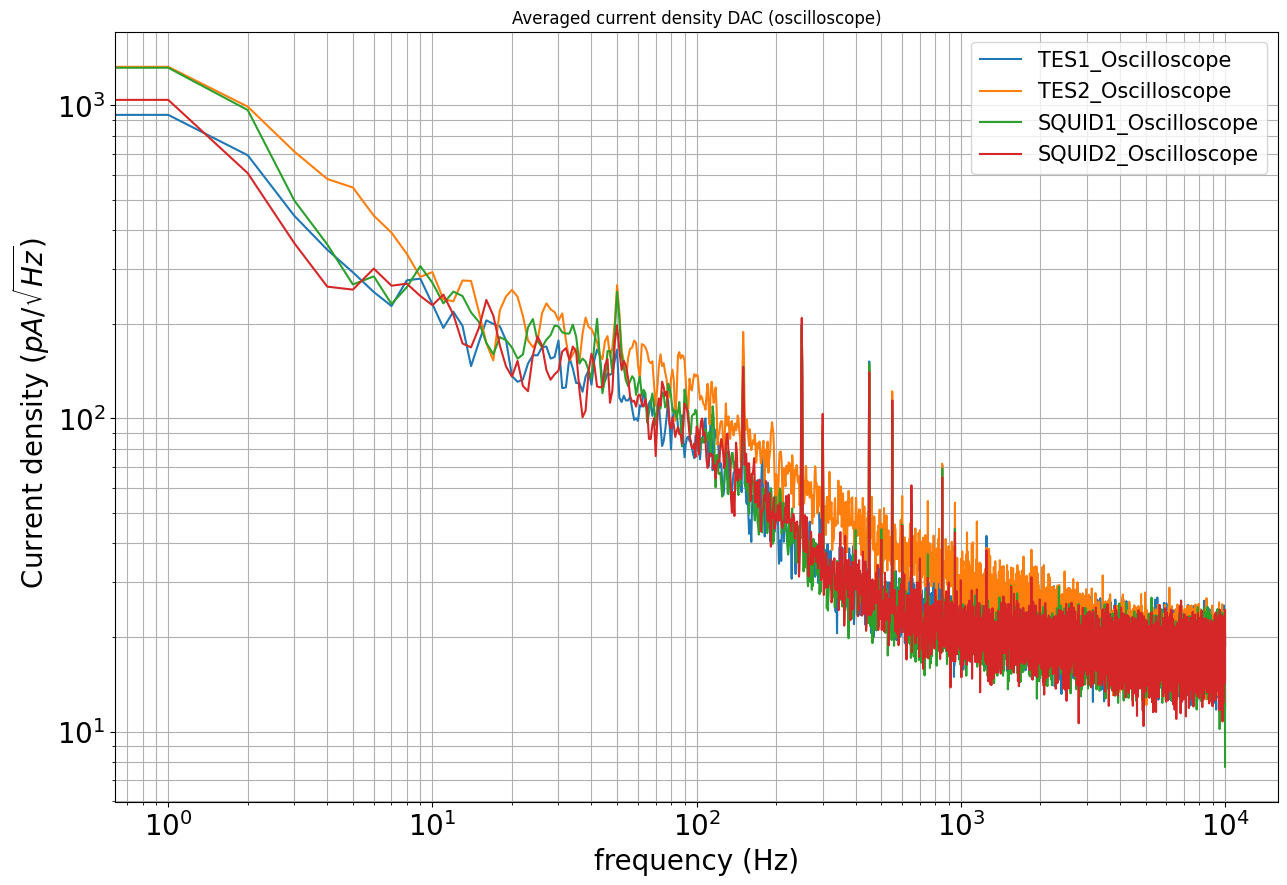

In [27]:
name = [  'TES1_Oscilloscope'
        , 'TES2_Oscilloscope'
        , 'SQUID1_Oscilloscope'
        , 'SQUID2_Oscilloscope']
plt.figure(figsize = (15,10))
plt.title('Averaged current density DAC (oscilloscope)')
for i in range(len(OSCILLO_analyse)):
    f,va = PSD_avg(OSCILLO_analyse[i][0]*factor, Fs, BW, 20000)
    plt.loglog(f,va, label = f'{name[i]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

### Compare plot between Spectral analyser and Oscilloscope (board 3 v4.5 with battery)

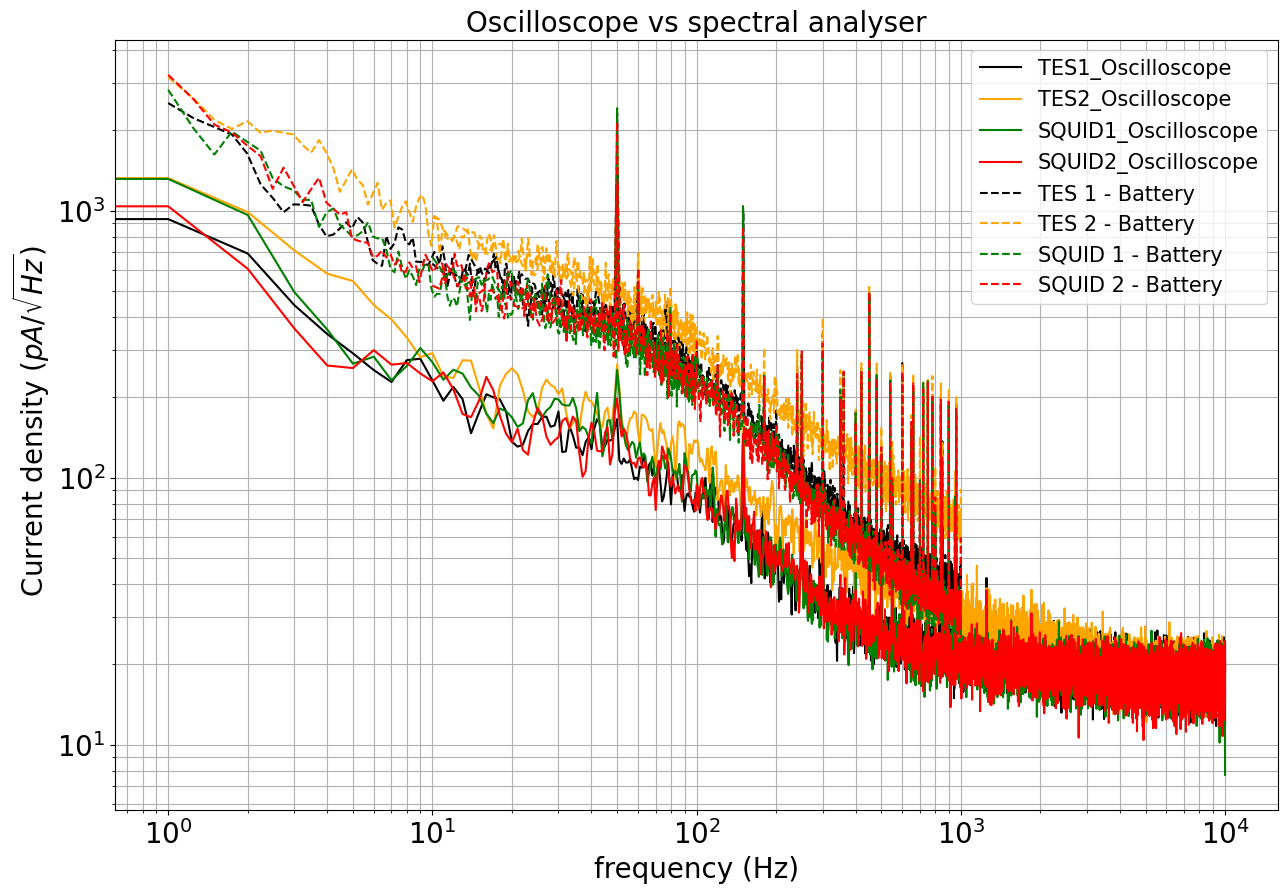

In [28]:
plt
plt.figure(figsize = (15,10))
plt.title('Oscilloscope vs spectral analyser', fontsize = 20)
for i in range(len(OSCILLO_analyse)):
    f,va = PSD_avg(OSCILLO_analyse[i][0]*factor, Fs, BW, 20000)
    # f,va = compute_power_spectral_density(OSCILLO_analyse[i][0]*factor, Fs, len(OSCILLO_analyse[i][0]), BW)
    plt.loglog(f,va, color = color[i], label = f'{name[i]}')
#TES_LF 
plt.loglog(TES1BA_LF[:,0], TES1BA_LF[:,1]*factor,linestyle = 'dashed', color = color[0], label = 'TES 1 - Battery' )
plt.loglog(TES2BA_LF[:,0], TES2BA_LF[:,1]*factor,linestyle = 'dashed', color = color[1], label = 'TES 2 - Battery' )
plt.loglog(TES1BA_HF[:,0], TES1BA_HF[:,1]*factor,linestyle = 'dashed', color = color[0] )
plt.loglog(TES2BA_HF[:,0], TES2BA_HF[:,1]*factor,linestyle = 'dashed', color = color[1] )
plt.loglog(SQI1BA_LF[:,0], SQI1BA_LF[:,1]*factor,linestyle = 'dashed', color = color[2], label = 'SQUID 1 - Battery' )
plt.loglog(SQI2BA_LF[:,0], SQI2BA_LF[:,1]*factor,linestyle = 'dashed', color = color[3], label = 'SQUID 2 - Battery' )
plt.loglog(SQI1BA_HF[:,0], SQI1BA_HF[:,1]*factor,linestyle = 'dashed', color = color[2] )
plt.loglog(SQI2BA_HF[:,0], SQI2BA_HF[:,1]*factor,linestyle = 'dashed', color = color[3] )
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

## 1.3.  CMB S4 Board 3

In [29]:
### TES_LF
CMB_TES1PS_LF = np.genfromtxt('data/cmbs4/CMBT0LPS.TXT') 
CMB_TES2PS_LF = np.genfromtxt('data/cmbs4/CMBT1LPS.TXT') 
CMB_TES1PS_HF = np.genfromtxt('data/cmbs4/CMBT0HPS.TXT') 
CMB_TES2PS_HF = np.genfromtxt('data/cmbs4/CMBT1HPS.TXT')
CMB_SQI1PS_LF = np.genfromtxt('data/cmbs4/CMBS0LPS.TXT') 
CMB_SQI2PS_LF = np.genfromtxt('data/cmbs4/CMBS1LPS.TXT')
CMB_SQI1PS_HF = np.genfromtxt('data/cmbs4/CMBS0HPS.TXT') 
CMB_SQI2PS_HF = np.genfromtxt('data/cmbs4/CMBS1HPS.TXT')
CMB_SQI1PS_UF = np.genfromtxt('data/cmbs4/CMBS0UPS.TXT')
CMB_TES2PS_UF = np.genfromtxt('data/cmbs4/CMBT1UPS.TXT')
CMB_SQI2PS_UF = np.genfromtxt('data/cmbs4/CMBS1UPS.TXT') 
CMB_TES1PS_UF = np.genfromtxt('data/cmbs4/CMBT0UPS.TXT') 

 

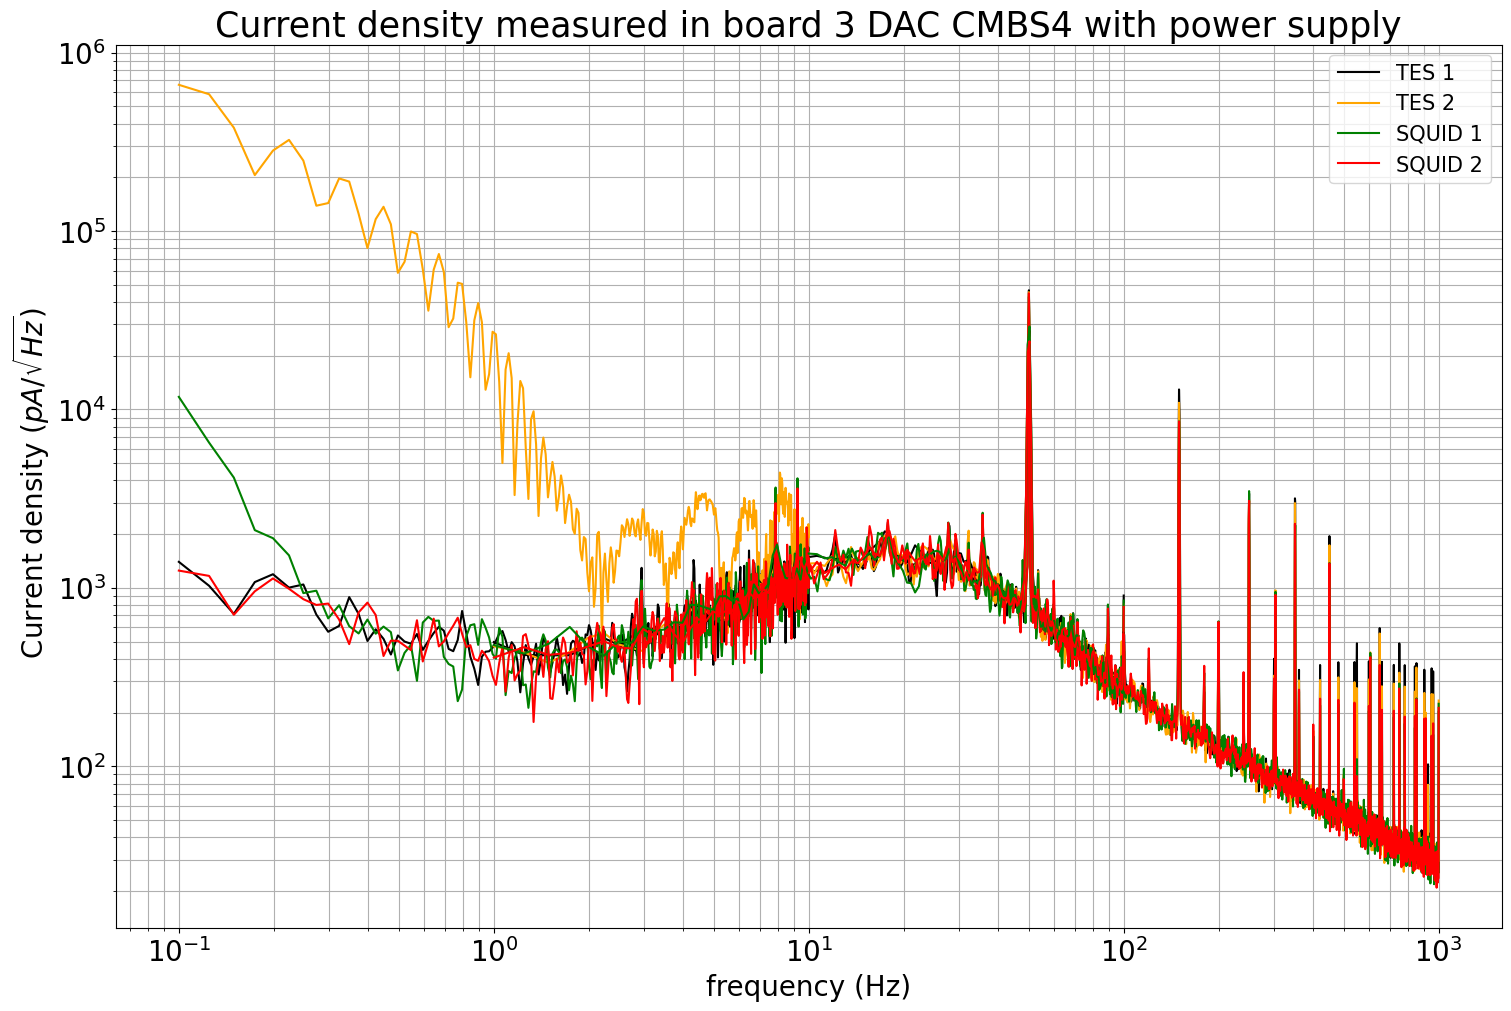

In [30]:
#TES_LF 
plt.figure(figsize = (15,10), constrained_layout=True)
plt.loglog(CMB_TES1PS_UF[:,0], CMB_TES1PS_UF[:,1]*factor, color = color[0] )
plt.loglog(CMB_TES2PS_UF[:,0], CMB_TES2PS_UF[:,1]*factor, color = color[1] )

plt.loglog(CMB_TES1PS_LF[:,0], CMB_TES1PS_LF[:,1]*factor, color = color[0], label = 'TES 1' )
plt.loglog(CMB_TES2PS_LF[:,0], CMB_TES2PS_LF[:,1]*factor, color = color[1], label = 'TES 2' )

plt.loglog(CMB_TES1PS_HF[:,0], CMB_TES1PS_HF[:,1]*factor, color = color[0] )
plt.loglog(CMB_TES2PS_HF[:,0], CMB_TES2PS_HF[:,1]*factor, color = color[1] )

plt.loglog(CMB_SQI1PS_UF[:,0], CMB_SQI1PS_UF[:,1]*factor, color = color[2] )
plt.loglog(CMB_SQI2PS_UF[:,0], CMB_SQI2PS_UF[:,1]*factor, color = color[3] )

plt.loglog(CMB_SQI1PS_LF[:,0], CMB_SQI1PS_LF[:,1]*factor, color = color[2], label = 'SQUID 1' )
plt.loglog(CMB_SQI2PS_LF[:,0], CMB_SQI2PS_LF[:,1]*factor, color = color[3], label = 'SQUID 2' )

plt.loglog(CMB_SQI1PS_HF[:,0], CMB_SQI1PS_HF[:,1]*factor, color = color[2] )
plt.loglog(CMB_SQI2PS_HF[:,0], CMB_SQI2PS_HF[:,1]*factor, color = color[3] )


plt.gca().set_title('Current density measured in board 3 DAC CMBS4 with power supply',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.savefig('CMBS4noise_powersupply.png')

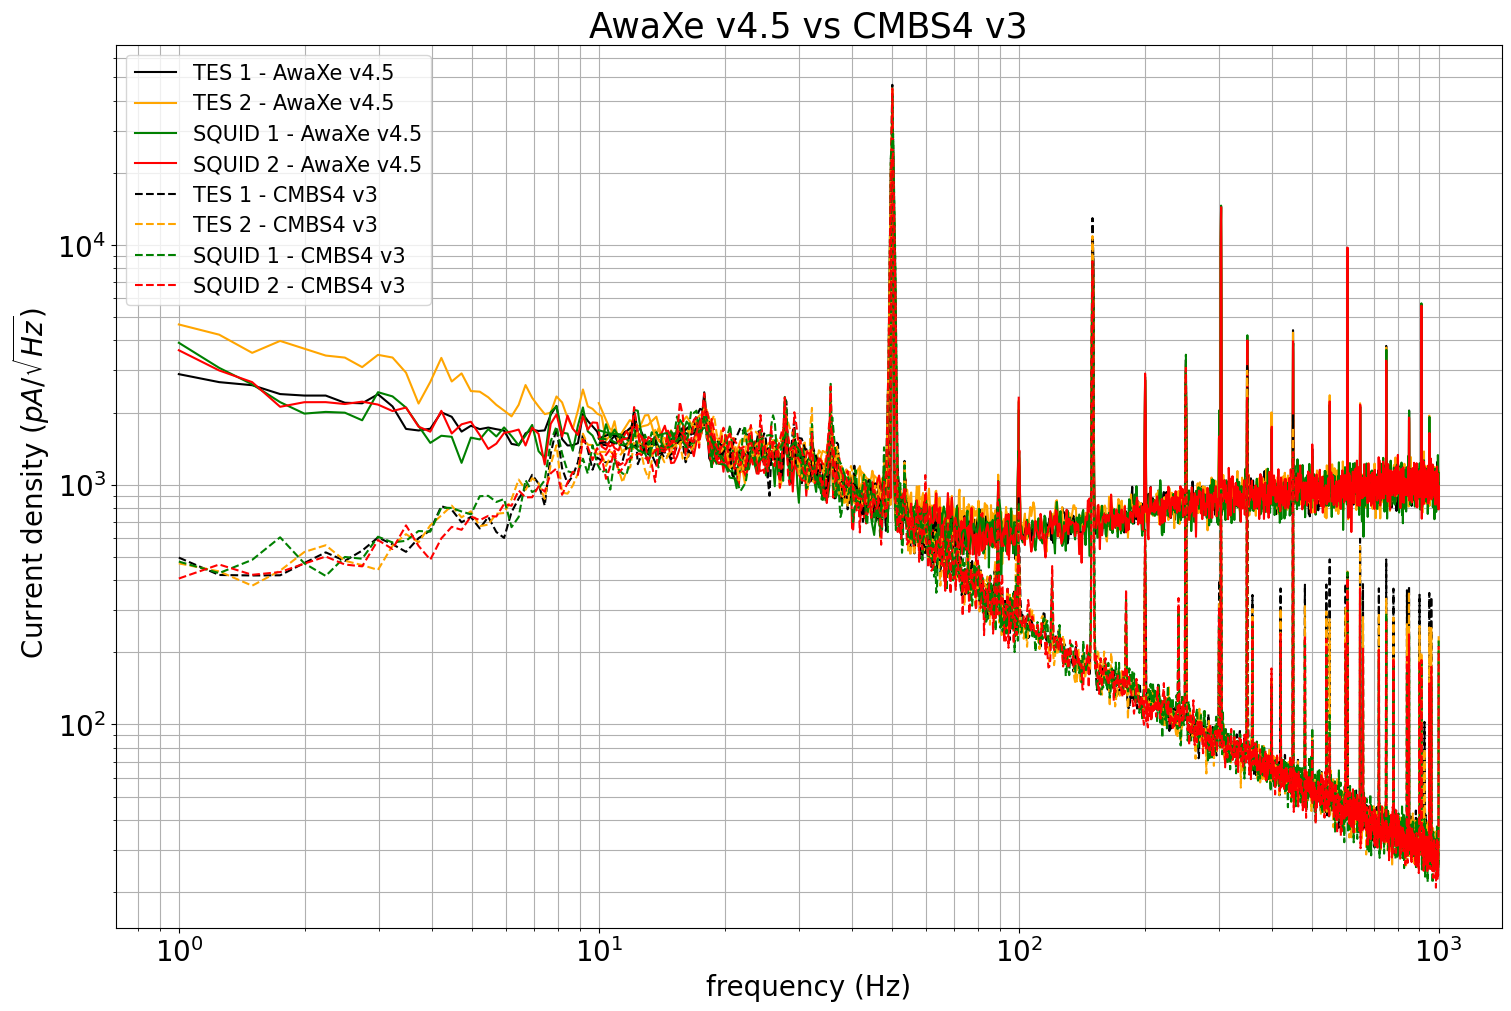

In [31]:
plt.figure(figsize = (15,10), constrained_layout=True)
#TES_LF 
plt.loglog(TES1_LF[:,0], TES1_LF[:,1]*factor, color = color[0], label = 'TES 1 - AwaXe v4.5' )
plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor, color = color[1], label = 'TES 2 - AwaXe v4.5' )
#TES_HF 
plt.loglog(TES1_HF[:,0], TES1_HF[:,1]*factor, color = color[0] )
plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor, color = color[1] )
#SQUID_LF 
plt.loglog(SQI1_LF[:,0], SQI1_LF[:,1]*factor, color = color[2], label = 'SQUID 1 - AwaXe v4.5' )
plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor, color = color[3], label = 'SQUID 2 - AwaXe v4.5' )
#SQUID_HF 
plt.loglog(SQI1_HF[:,0], SQI1_HF[:,1]*factor, color = color[2] )
plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor, color = color[3] )



# plt.loglog(CMB_TES1PS_UF[:,0], CMB_TES1PS_UF[:,1]*factor, color = color[0] )
# plt.loglog(CMB_TES2PS_UF[:,0], CMB_TES2PS_UF[:,1]*factor, color = color[1] )

plt.loglog(CMB_TES1PS_LF[:,0], CMB_TES1PS_LF[:,1]*factor, linestyle = 'dashed', color = color[0], label = 'TES 1 - CMBS4 v3' )
plt.loglog(CMB_TES2PS_LF[:,0], CMB_TES2PS_LF[:,1]*factor, linestyle = 'dashed', color = color[1], label = 'TES 2 - CMBS4 v3' )
plt.loglog(CMB_TES1PS_HF[:,0], CMB_TES1PS_HF[:,1]*factor, linestyle = 'dashed', color = color[0] )
plt.loglog(CMB_TES2PS_HF[:,0], CMB_TES2PS_HF[:,1]*factor, linestyle = 'dashed', color = color[1] )
plt.loglog(CMB_SQI1PS_LF[:,0], CMB_SQI1PS_LF[:,1]*factor, linestyle = 'dashed', color = color[2], label = 'SQUID 1 - CMBS4 v3' )
plt.loglog(CMB_SQI2PS_LF[:,0], CMB_SQI2PS_LF[:,1]*factor, linestyle = 'dashed', color = color[3], label = 'SQUID 2 - CMBS4 v3' )
plt.loglog(CMB_SQI1PS_HF[:,0], CMB_SQI1PS_HF[:,1]*factor, linestyle = 'dashed', color = color[2] )
plt.loglog(CMB_SQI2PS_HF[:,0], CMB_SQI2PS_HF[:,1]*factor, linestyle = 'dashed', color = color[3] )


plt.gca().set_title('AwaXe v4.5 vs CMBS4 v3',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.savefig('AWaXev4.5vsCMBS4v3.png')



# Appendix

## Side analyse 

This analyse, we are going to compare the power spectral density of two signal 
* Signal that averaged in time domain
* Original signal 

In [69]:
count = 0
avg_timedomain = np.zeros(Fs)
for i in range(len(OSCILLO_TES1BA[0]) // 20000):
    avg_timedomain +=  np.array(OSCILLO_TES1BA[0][count:count + Fs])
    count += Fs
avg_timedomain = avg_timedomain / (len(OSCILLO_TES1BA[0]) // 20000)


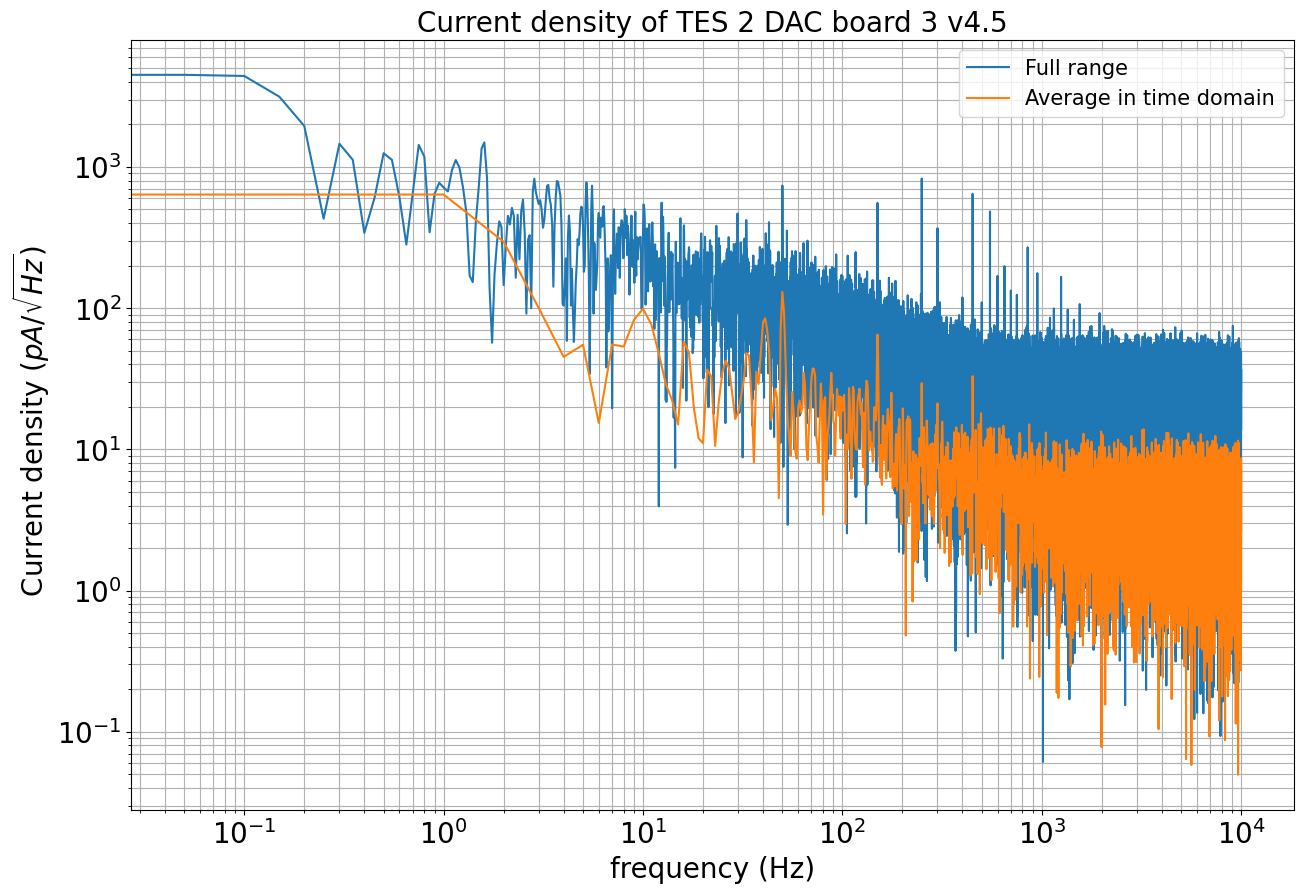

In [84]:
# plt.plot(avg_timedomain)
f,va = PSD_avg(OSCILLO_analyse[0][0]*factor, Fs, BW, 20000)
f_avg_tdm,va_avg_tdm = compute_power_spectral_density(avg_timedomain*factor, Fs, len(avg_timedomain), BW)
f_test,va_test = compute_power_spectral_density(OSCILLO_TES1BA[0]*factor, Fs, len(OSCILLO_TES1BA[0]), BW)

plt.figure(figsize = (15,10))
plt.title('Current density of TES 2 DAC board 3 v4.5', fontsize = 20)
# plt.loglog(f,va, label ='Full range')
plt.loglog(f_test,va_test, label ='Full range')
plt.loglog(f_avg_tdm,va_avg_tdm, label ='Average in time domain')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
# plt.legend()
plt.savefig('signalvsaverage.png')

In [67]:
# print(type(OSCILLO_TES1BA[0]))

<class 'pandas.core.series.Series'>


### DACv4.5board2 measure 1

In [32]:
data = pd.read_csv('06112024/C1--dacv45bord2--00000.csv', skiprows=9, header=None) # No header
data_ms1 = data

In [33]:
# FS = 1000
#(Gain SR560 = 1000 ; /2 at the input of the oscilloscope, load = 510Ω) 
fac = 1e12/(510*1000) 
#1e12 to convert to pA
# *2 due to the division by the oscilloscope 
# 510 * 1000 due to the load 


N =  1/(data[0][1] - data[0][0])
print(f'N = {N}')
fre, val = compute_power_spectral_density(data[1]*fac, N, 50002)
# fre, val = PSD(data[1], 2/(data[0][1] - data[0][0]))
plt.figure(figsize = (15,10))
plt.subplot(211)
plt.plot(data[0],data[1]*fac, label = 'Data in time domain')
plt.xlabel('time (s)')
plt.xlim(0,0.1)
plt.ylabel(r'Current $(pA)$')
plt.subplot(212)
plt.loglog(fre, np.sqrt(val), label = 'PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$')
plt.grid(True, which="both")
print(1/(data[0][1] - data[0][0]))
print(np.size(fre))

N = 2497.5024975013157


TypeError: compute_power_spectral_density() missing 1 required positional argument: 'bandwidth'

In [ ]:
# test sample: data1 
factor = fac
#we divide it to 10 ranges 
# r = np.arange(0,10,1)

avg = np.zeros(np.size(data[0][data_selection(i,i+1, data[0])])//2+1)
plt.figure(figsize = (15,10))
plt.subplot(211)
for i in range(10): 
    fre, val = compute_power_spectral_density(data[1][data_selection(i,i+1, data[0])]*fac, N, 2500)
    avg += (val)
    plt.loglog(fre,np.sqrt(val), label = f'PSD from {i} s to {i+1} s')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.title('Compare the drift in board 2 DACv4.5',fontsize = 25) 
plt.subplot(212)
plt.loglog(fre,np.sqrt(avg/10), label = f'averaging board 2 DACv4.5')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

### DACv4.5 board2 measure 2

In [ ]:
data = pd.read_csv('06112024/C1--dacv45bord2--00001.csv', skiprows=9, header=None) # No header
data_ms2 = data

In [ ]:
# FS = 1000
# fac = 1e12/(2*500000) #factor divided by 2


N =  1/(data[0][1] - data[0][0])
print(f'N = {N}')
fre, val = compute_power_spectral_density(data[1]*fac, N, 50002)
# fre, val = PSD(data[1], 2/(data[0][1] - data[0][0]))
plt.figure(figsize = (15,10))
plt.subplot(211)
plt.plot(data[0],data[1]*fac, label = 'Data in time domain')
plt.xlabel('time (s)')
plt.xlim(0,0.1)
plt.ylabel(r'Current $(pA)$')
plt.subplot(212)
plt.loglog(fre, np.sqrt(val), label = 'PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$')
plt.grid(True, which="both")
print(1/(data[0][1] - data[0][0]))
print(np.size(fre))

In [ ]:
# test sample: data1 
# factor = fac
#we divide it to 10 ranges 
# r = np.arange(0,10,1)

avg = np.zeros(np.size(data[0][data_selection(i,i+1, data[0])])//2+1)
plt.figure(figsize = (15,10))
plt.subplot(211)
for i in range(10): 
    fre, val = compute_power_spectral_density(data[1][data_selection(i,i+1, data[0])]*fac, N, 2500)
    avg += (val)
    plt.loglog(fre,np.sqrt(val), label = f'PSD from {i} s to {i+1} s')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.title('Compare the drift in board 2 DACv4.5',fontsize = 25) 
plt.subplot(212)
plt.loglog(fre,np.sqrt(avg/10), label = f'averaging board 2 DACv4.5')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")